In [248]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [249]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('../doge_v1.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df.head()


,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,...,subscribers,total_issues,closed_issues,pull_requests_merged,pull_request_contributors,commit_count_4_weeks,dogecoin_unscaled,dogecoin_monthly,scale,dogecoin
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,165257.000000,0.633,9.490,81680.0,...,225.0,395.000000,336.0,732.0,67.0,0.0,57,1.0,0.01,0.57
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,165308.000000,0.833,11.958,81723.0,...,225.0,395.166667,336.0,732.0,67.0,0.0,24,1.0,0.01,0.24
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,165363.000000,0.980,13.224,81772.0,...,225.0,395.333333,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,165402.000000,1.102,14.469,81831.0,...,225.0,395.500000,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,165452.666667,1.277,15.383,81878.0,...,225.0,395.666667,336.0,732.0,67.0,0.0,41,1.0,0.01,0.41


In [250]:
pd.date_range(start = '2017-11-09', end = '2022-02-04' ).difference(df.index)


DatetimeIndex(['2021-04-16', '2021-05-05', '2021-05-09'], dtype='datetime64[ns]', freq=None)

In [251]:

df = df.resample('D').ffill()

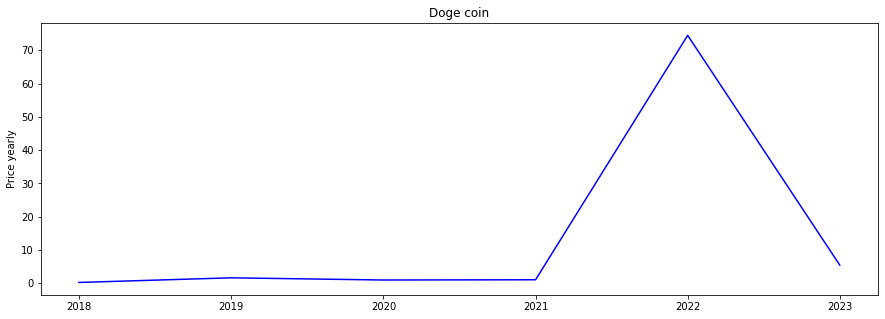

In [252]:
df_yearly = df.resample('Y').sum()
plt.figure(figsize=(15,5))
plt.ylabel('Price yearly')
plt.title('Doge coin')
plt.plot(df_yearly.Close,'b-');


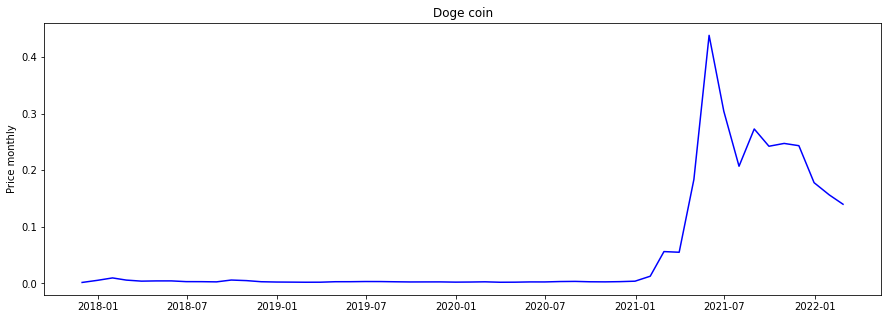

In [253]:
df_monthly = df.resample('M').mean()
plt.figure(figsize=(15,5))
plt.ylabel('Price monthly')
plt.title('Doge coin')
plt.plot(df_monthly.Close,'b-');

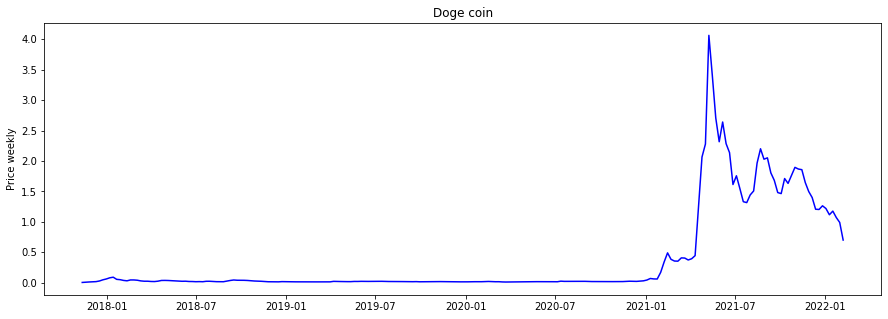

In [254]:
df_weekly= df.resample('W').sum()
plt.figure(figsize=(15,5))
plt.ylabel('Price weekly')
plt.title('Doge coin')
plt.plot(df_weekly.Close,'b-');

In [255]:
pd.date_range(start = '2017-11-09', end = '2022-02-04' ).difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

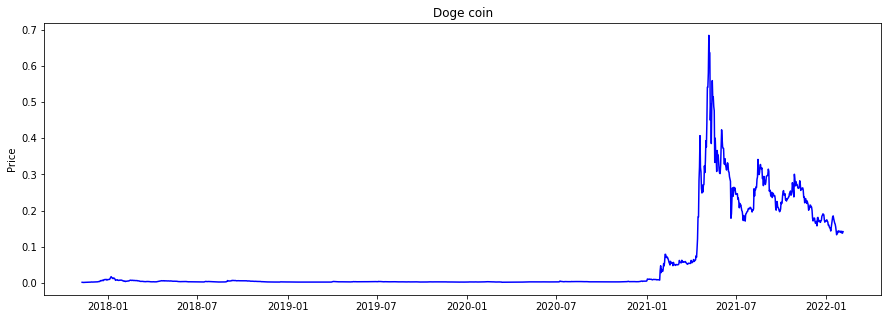

In [256]:
plt.figure(figsize=(15,5))
plt.ylabel('Price')
plt.title('Doge coin')
plt.plot(df['Close'],'b-');



In [257]:
#ADF pokazuje da nisu stacionarni podaci
X = df['Close'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.989048
p-value: 0.291396
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


In [258]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
kpss_test(df['Close'].values)


Results of KPSS Test:
Test Statistic            2.903298
p-value                   0.010000
Lags Used                25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [259]:
#Test stacionarnosti za podatke na nedeljnom nivou
kpss_test(df_monthly.Close.values)

Results of KPSS Test:
Test Statistic           0.636010
p-value                  0.019363
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [260]:
#Testiram ADF testom stacionarnost
from python_scripts.sarima_helper import check_stationarity

check_stationarity(df_monthly.Close)

False

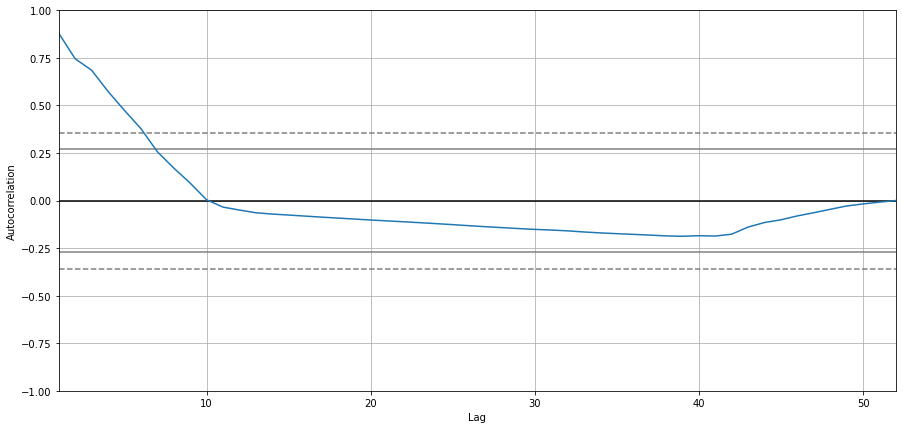

In [261]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

#Posto sam utvrdio sa 2 testa da nije stacionaran trebace d biti 1 ili vise
#Pravim grafik autokorelacije za podatke na mesecnom nivou
autocorrelation_plot(df_monthly.Close)
pyplot.show()

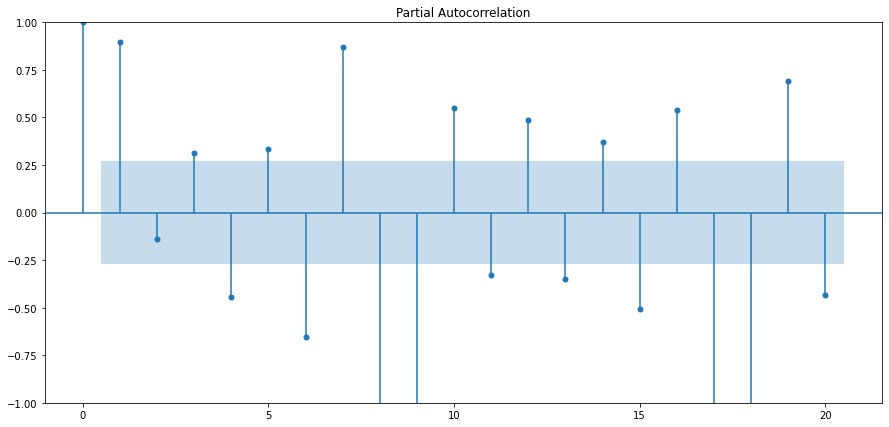

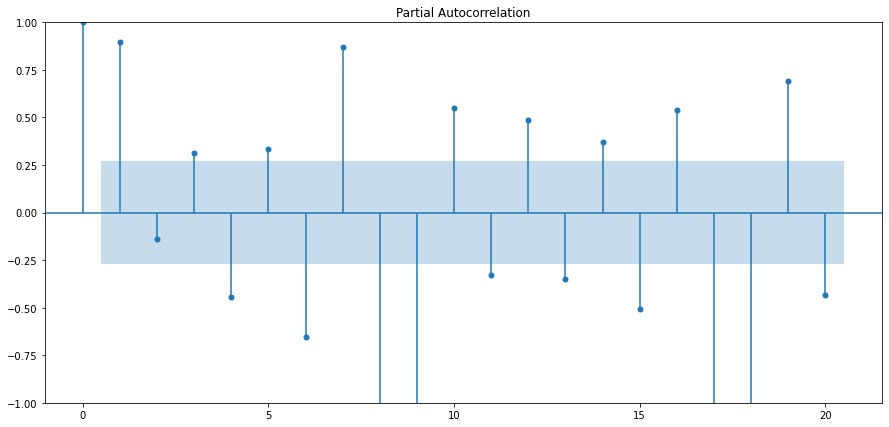

In [262]:
plot_pacf(df_monthly.Close, lags = 20)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   52
Model:                 ARIMA(1, 1, 5)   Log Likelihood                  90.250
Date:                Thu, 17 Feb 2022   AIC                           -166.499
Time:                        14:43:05   BIC                           -152.977
Sample:                    11-30-2017   HQIC                          -161.332
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2545      2.049      0.124      0.901      -3.761       4.270
ma.L1          0.0860      2.053      0.042      0.967      -3.938       4.110
ma.L2         -0.6327      0.703     -0.900      0.3

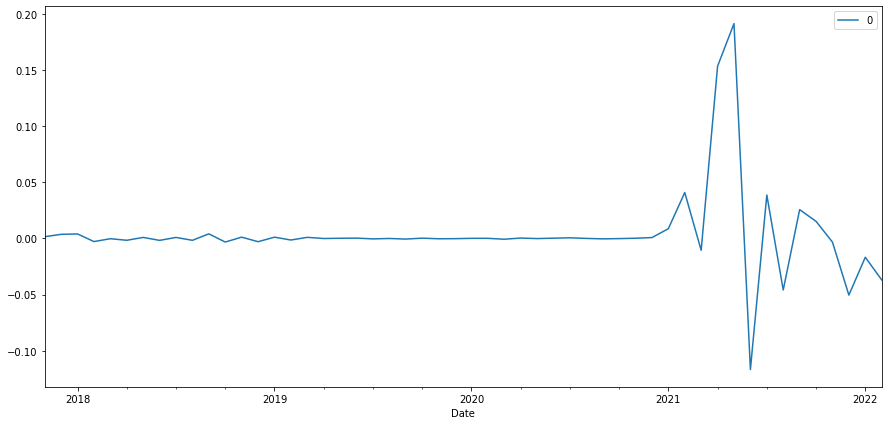

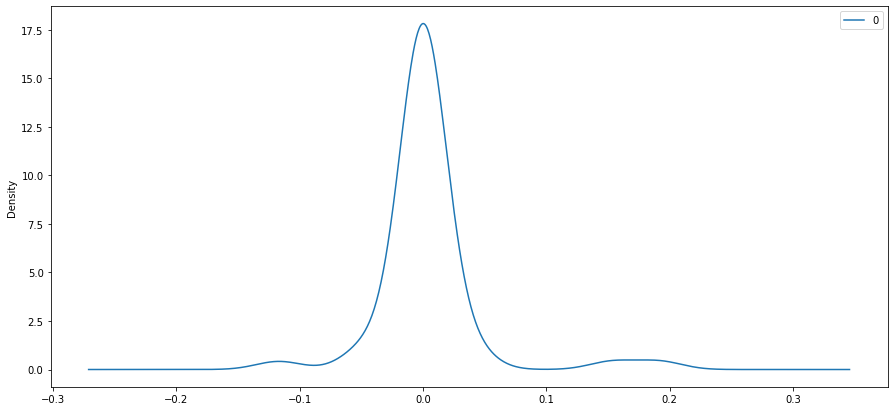

               0
count  52.000000
mean    0.003813
std     0.040540
min    -0.116781
25%    -0.001434
50%     0.000092
75%     0.001054
max     0.191549


In [263]:
#Ynacajna  parcijalna autokorelacija postoji u prvih 1 lagova
# fit model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_monthly.Close, order=(1,1,5))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

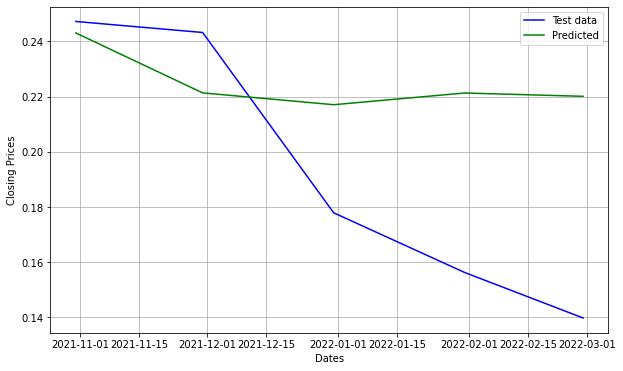

In [264]:
from python_scripts.sarima_helper import ArimaModelStats

#Mesecno predvidjanje
testNum = round(df_monthly.shape[0] * 0.1)
train = df_monthly.iloc[:-testNum]
test = df_monthly.iloc[-testNum:]

model = ARIMA(train.Close, order=(1,1,5))
model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA predictions')
model_stat  = ArimaModelStats(1, 1, 5,0, 0, 0, 0, abs(model_fit.aic),
                                               abs(model_fit.bic), 0, pred, test.Close)
model_stat.draw_graph()

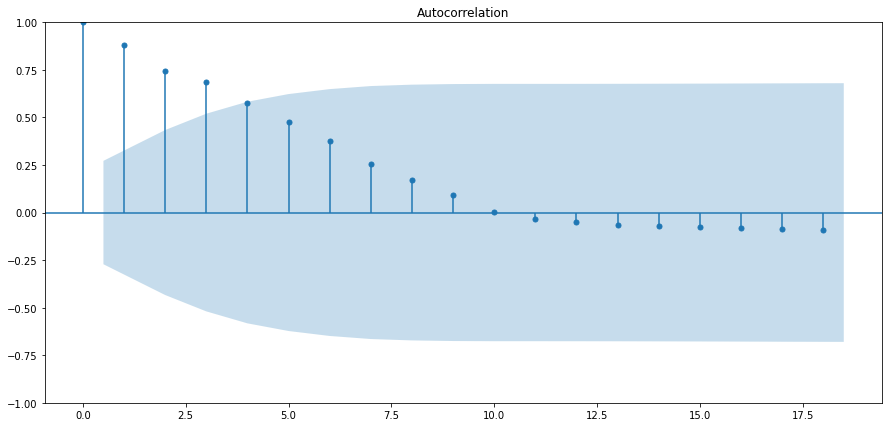

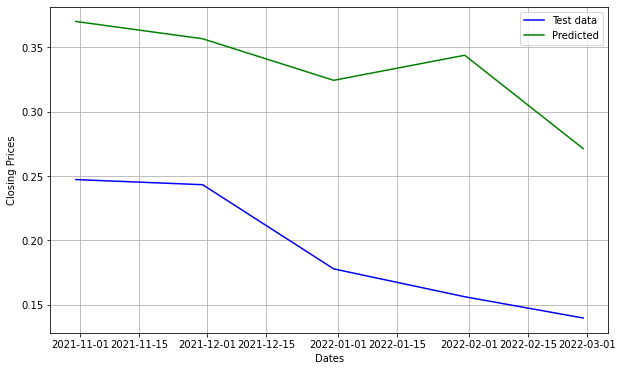

In [265]:
plot_acf(df_monthly.Close)
model = ARIMA(train.Close, order=(5,1,5))
model_fit = model.fit()
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA predictions')
model_stat  = ArimaModelStats(5, 1, 5,0, 0, 0, 0, abs(model_fit.aic),
                                               abs(model_fit.bic), 0, pred, test.Close)
model_stat.draw_graph()

In [266]:
#Pokusavamo poboljsati predvidjanje uvodjenjem Auto arima
from pmdarima import auto_arima
stepwise_fit = auto_arima(df_weekly.Close,
                          trace=True,
                          suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-128.958, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-128.440, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-129.949, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-129.361, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-130.371, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-128.944, Time=0.46 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.426 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  66.186
Date:                Thu, 17 Feb 2022   AIC                           -130.371
Time:                        14:43:16   BIC                           -126.973
Sample:                             0   HQIC                          -128.999
                                - 222                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0322      0.001     52.486      0.000       0.031       0.033
===================================================================================
Ljung-Box (L1) (Q):                   3.50   Jarque-Bera (JB):             21618.42
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):            1867.21   Skew:                             4.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        50.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

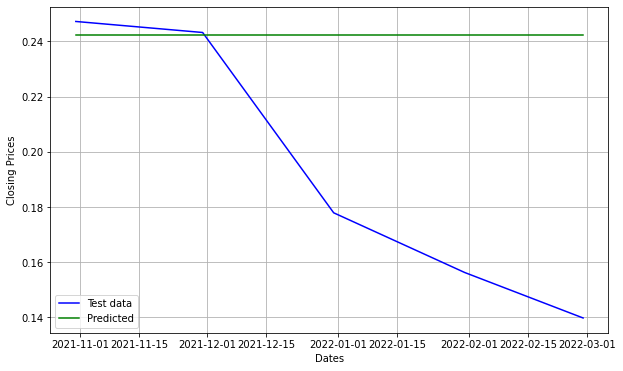

In [267]:
model = ARIMA(train.Close, order=(0,1,0))
model_fit = model.fit()
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA predictions')
model_stat  = ArimaModelStats(0, 1, 0,0, 0, 0, 0, abs(model_fit.aic),
                                               abs(model_fit.bic), 0, pred, test.Close)
model_stat.draw_graph()


In [268]:
#Menjam parametre auto arima da proverim da li ide bolje
arima_model =  auto_arima(train.Close,start_p=0, d=1, start_q=0,
                          max_p=5, max_d=5, max_q=5, start_P=0,
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True,
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
arima_model.summary()



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-94.683, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-90.716, Time=0.96 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-90.834, Time=1.98 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-92.683, Time=0.42 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-92.683, Time=0.30 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-90.683, Time=0.61 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-92.716, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-92.835, Time=0.28 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-98.868, Time=1.09 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-96.555, Time=2.33 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-96.906, Time=1.89 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-94.872, Time=2.96 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=-100.265, Time=1.12 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=-98.364, Time=1.52 sec
 ARIMA(2,1,1)(0,1,1)[12]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   47
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                  54.133
Date:                             Thu, 17 Feb 2022   AIC                           -100.265
Time:                                     14:43:46   BIC                            -94.160
Sample:                                          0   HQIC                           -98.183
                                              - 47                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5524      0.489     -1.131      0.258      -1.510       0.405
ar.L2         -0.3400      0.228     -1.489      0.137      -0.787       0.108
ma.L1          0.8684      0.506      1.715      0.086      -0.124       1.861
sigma2         0.0023      0.000      5.628      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               107.23
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):            1029.95   Skew:                             1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

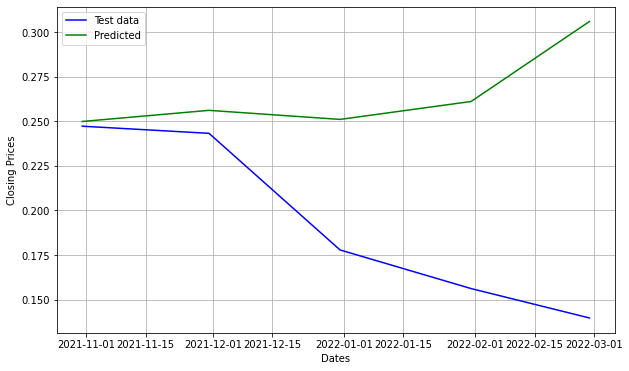

In [269]:
#Proveravamo tacnost novog modela predlozenog
model = ARIMA(train.Close, order=(2,1,1), seasonal_order=(0,1,0,12))
model_fit = model.fit()
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA predictions')
model_stat  = ArimaModelStats(2, 1, 1,0, 1, 0, 12, abs(model_fit.aic),
                                               abs(model_fit.bic), 0, pred, test.Close)
model_stat.draw_graph()


In [270]:
#Pokusavamo sa  nedeljnim predvidjanjem
#Testiram ADF testom stacionarnost
from python_scripts.sarima_helper import check_stationarity

check_stationarity(df_weekly.Close)

False

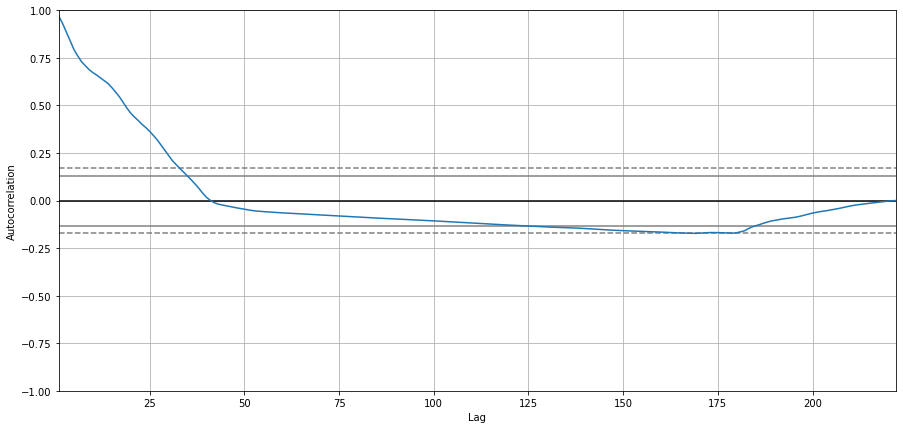

In [271]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

#Posto sam utvrdio sa 2 testa da nije stacionaran trebace d biti 1 ili vise
#Pravim grafik autokorelacije za podatke na nedeljnom nivou
autocorrelation_plot(df_weekly.Close)
pyplot.show()


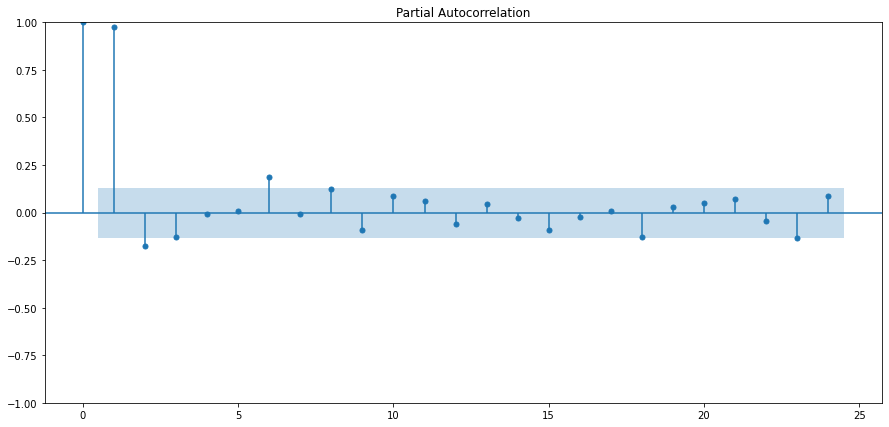

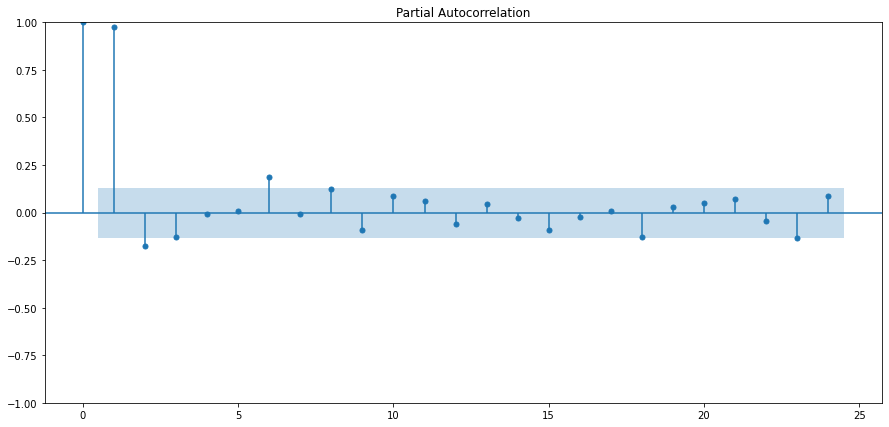

In [272]:
plot_pacf(df_weekly.Close)


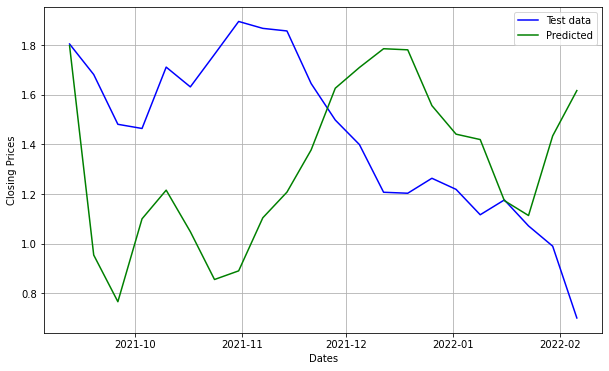

In [273]:
#Mesecno predvidjanje
testNum = round(df_weekly.shape[0] * 0.1)
train = df_weekly.iloc[:-testNum]
test = df_weekly.iloc[-testNum:]

model = ARIMA(train.Close, order=(26,1,2))
model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA predictions')
model_stat  = ArimaModelStats(26, 1, 2,0, 0, 0, 0, abs(model_fit.aic),
                                               abs(model_fit.bic), 0, pred, test.Close)
model_stat.draw_graph()


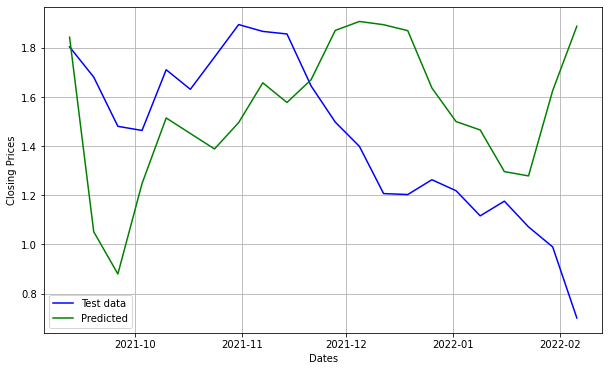

In [274]:
model = ARIMA(train.Close, order=(23,1,2))
model_fit = model.fit()
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA predictions')
model_stat  = ArimaModelStats(23, 1, 2,0, 0, 0, 0, abs(model_fit.aic),
                                               abs(model_fit.bic), 0, pred, test.Close)
model_stat.draw_graph()


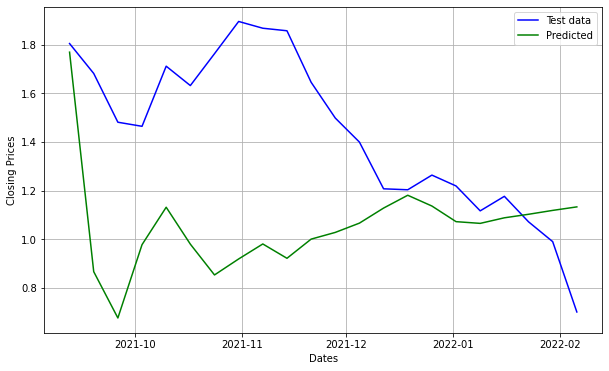

In [275]:
model = ARIMA(train.Close, order=(2,1,28))
model_fit = model.fit()
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA predictions')
model_stat  = ArimaModelStats(23, 1, 25,0, 0, 0, 0, abs(model_fit.aic),
                                               abs(model_fit.bic), 0, pred, test.Close)
model_stat.draw_graph()


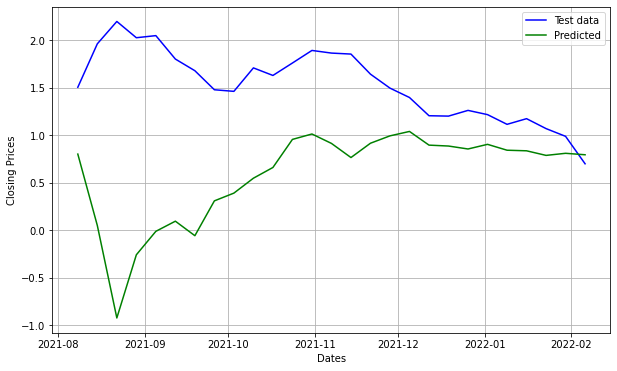

In [276]:
testNum = round(df_weekly.shape[0] * 0.12)
train = df_weekly.iloc[:-testNum]
test = df_weekly.iloc[-testNum:]
start = len(train)
end = len(train) + len(test) - 1
model = ARIMA(train.Close, order=(2,1,28))
model_fit = model.fit()
pred = model_fit.predict(start=start, end=end, typ='levels').rename('ARIMA predictions')
model_stat  = ArimaModelStats(23, 1, 25,0, 0, 0, 0, abs(model_fit.aic),
                                               abs(model_fit.bic), 0, pred, test.Close)
model_stat.draw_graph()


In [277]:
kpss_test(df.Close)


Results of KPSS Test:
Test Statistic            2.903298
p-value                   0.010000
Lags Used                25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [278]:
check_stationarity(df.Close)

False

In [279]:
df['first_diff'] = df['Close'] - df['Close'].shift(1)

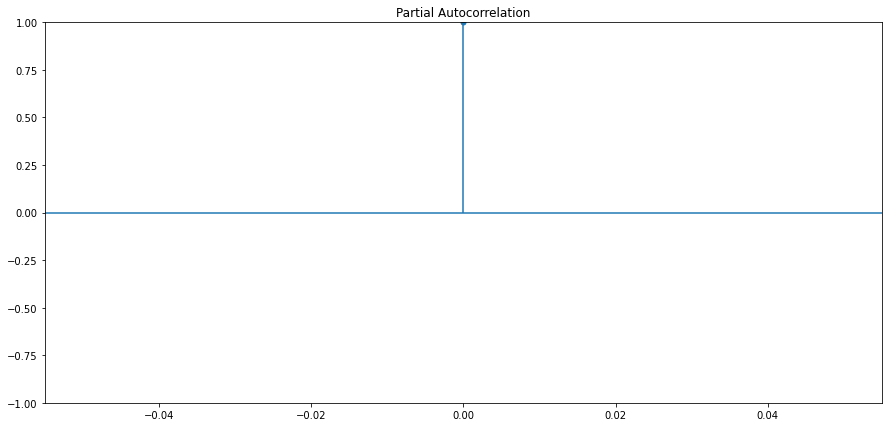

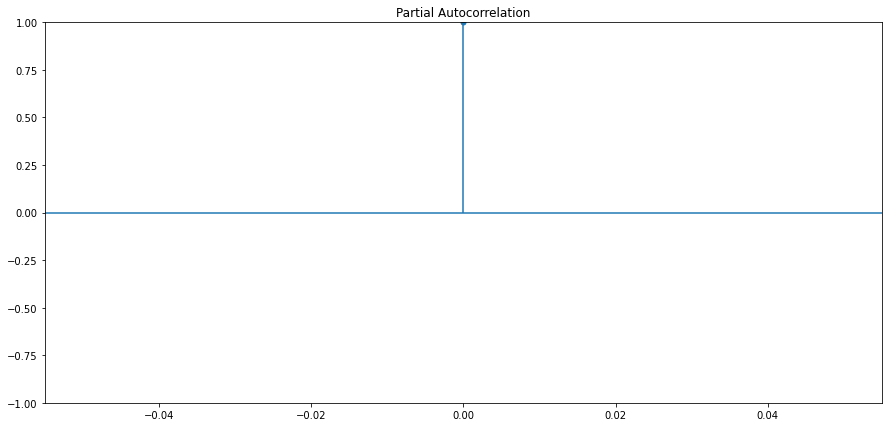

In [282]:
plot_pacf(df.Close)

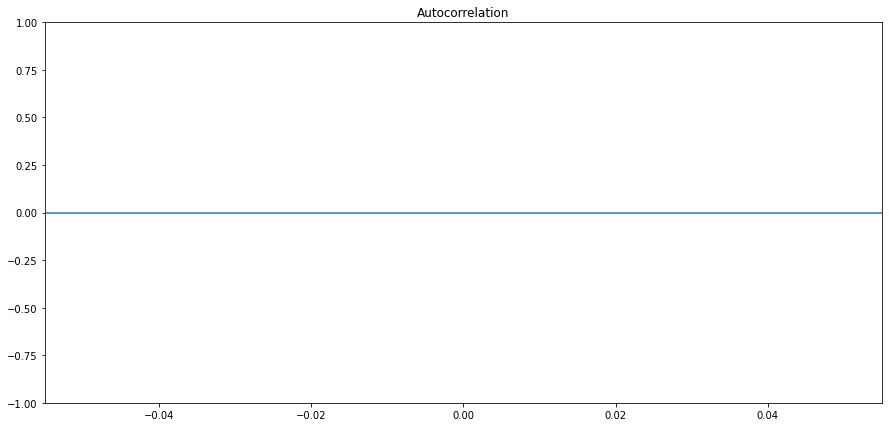

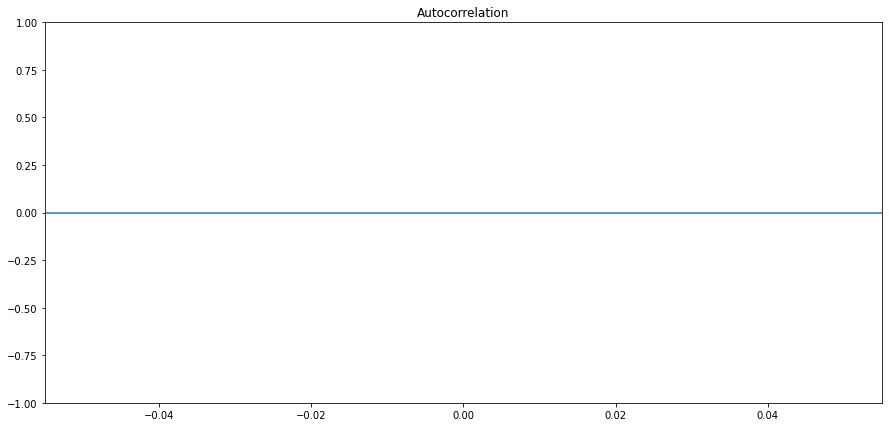

In [283]:
plot_acf(df.Close)
